In [1]:
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
import polars as pl

from astroLuSt.synthetics import random as alr
from astroLuSt.preprocessing import dataseries_manipulation as aldm

#import model code
from astroLuSt.ai.models import periodlstm

import importlib

# Generate Training Data

## Homogeneous Data

(20, 100) (20, 100)


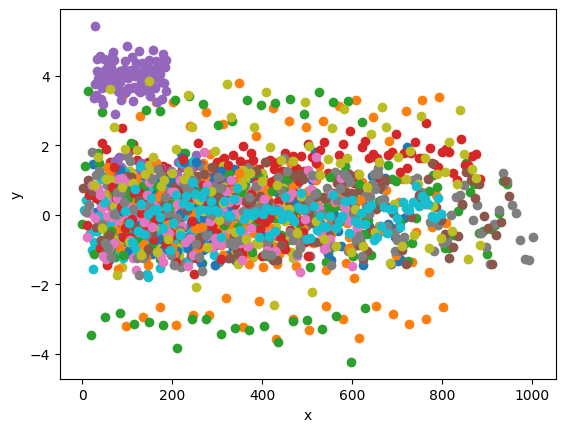

In [29]:
importlib.reload(alr)
importlib.reload(aldm)

nsamples = 20
periods = np.random.uniform(0.1, 100, (nsamples,1))
npoints = np.zeros(nsamples) + 100
x_offsets = np.random.randint(0, 100, nsamples)

GPS = alr.GeneratePeriodicSignals(
    periods=periods,
    npoints=npoints,
    x_offsets=x_offsets,
)
# print(GPS)

x_gen, y_gen = GPS.rvs(
    shape=None,
    # shape=(5,20),
    choices=None,
    x=None,
    noise_level_x=0.2,
    noise_level_y=0.4,
    func_kwargs=None
)

print(x_gen.shape, y_gen.shape)

fig, axs = GPS.plot_result()
plt.show()

# for idx in range(3):
#     plt.scatter(aldm.fold(x_gen[idx], periods[idx])[0], y_gen[idx])

X = []
for xi, yi in zip(x_gen, y_gen):
    # print(xi.shape, yi.shape)
    xy = np.append(xi.reshape(-1,1), yi.reshape(-1,1), axis=1)
    X.append(xy)
X = np.array(X, dtype=object)

np.save('./data/X_aiperiod_homogeneous.npy', X)
np.save('./data/y_aiperiod_homogeneous.npy', periods)


## Heterogeneous Data

HERE


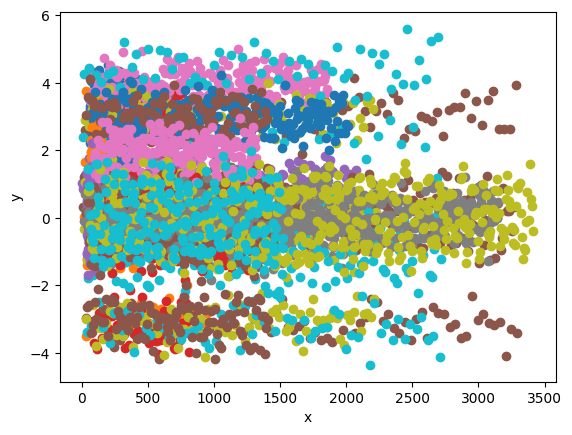

In [30]:
importlib.reload(alr)
importlib.reload(aldm)

nsamples = 20
periods = np.random.uniform(0.1, 100, (nsamples,1))
npoints = np.random.randint(130, 500, nsamples)
x_offsets = np.random.randint(0, 100, (nsamples,1))

GPS = alr.GeneratePeriodicSignals(
    periods=periods,
    npoints=npoints,
    x_offsets=x_offsets,
)
# print(GPS)

x_gen, y_gen = GPS.rvs(
    shape=None,
    # shape=(5,20),
    choices=None,
    x=None,
    noise_level_x=0.2,
    noise_level_y=0.4,
    func_kwargs=None
)

fig, axs = GPS.plot_result()
plt.show()

# for idx in range(3):
#     plt.scatter(aldm.fold(x_gen[idx], periods[idx])[0], y_gen[idx])

X = []
for xi, yi in zip(x_gen, y_gen):
    # print(xi.shape, yi.shape)
    xy = np.append(xi.reshape(-1,1), yi.reshape(-1,1), axis=1)
    X.append(xy)
X = np.array(X, dtype=object)

np.save('./data/X_aiperiod_heterogeneous.npy', X)
np.save('./data/y_aiperiod_heterogeneous.npy', periods)


In [25]:
X = np.load('./data/X_periods_heterogeneous.npy', allow_pickle=True)
y = np.load('./data/y_periods_heterogeneous.npy', allow_pickle=True)

print(X.shape)
print(y.shape)

(20,)
(20, 1)


# Train LSTM

In [3]:
importlib.reload(periodlstm)

#hyperparameters
input_shape = (50, 2)  # Assuming input sequences of length 50 and 2 feature
hidden_units = 32  # Number of units in the LSTM layer
output_units = 2  # Number of output units

#Instantiate the LSTM
lstm_model = periodlstm.PeriodLSTM(input_shape, hidden_units, output_units)

# Build and compile the model
model = lstm_model.build_model()
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50, 2)]           0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                4480      
                                                                 
 dense_1 (Dense)             (None, 2)                 66        
                                                                 
Total params: 4,546
Trainable params: 4,546
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, shuffle=True)

# Make predictions
predictions = model.predict(X_test)
print(predictions)

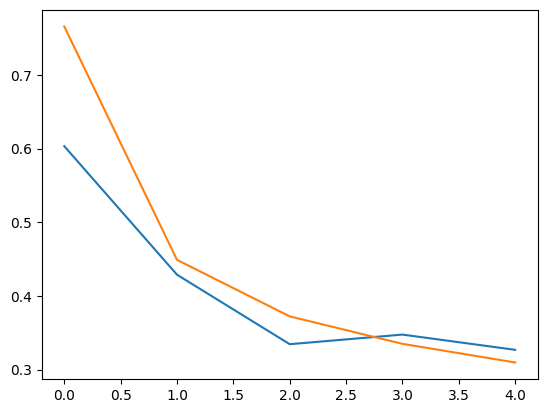

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

625/625 [==============================] - 5s 7ms/step
0.32004217999508033


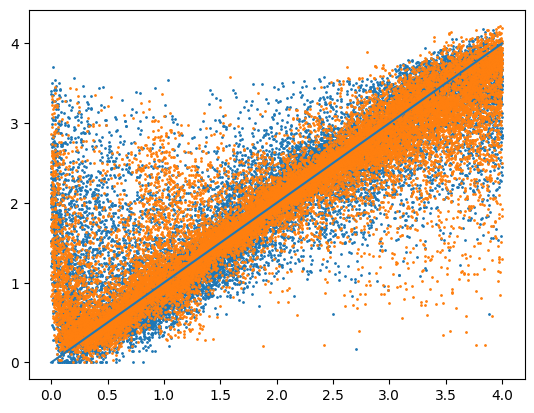

In [ ]:

y_pred = model.predict(X_test)
print(mean_squared_error(y_test, y_pred))

plt.scatter(y_test[:,0], y_pred[:,0], s=1)
plt.scatter(y_test[:,1], y_pred[:,1], s=1)
plt.plot(np.linspace(0,4,100), np.linspace(0,4,100))




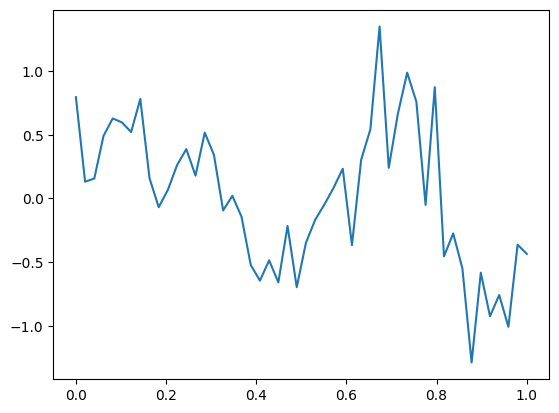

In [ ]:
plt.plot(X_train[0,:,0], X_train[0,:,1])

1/1 [==============================] - 0s 47ms/step


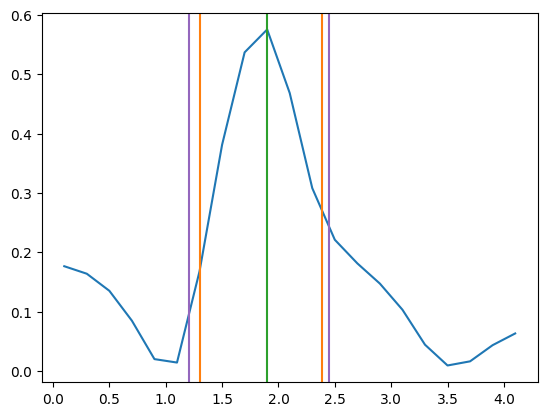

In [ ]:
%matplotlib inline


LS = LombScargle(X_train[0,:,0], X_train[0,:,1])

freq, power = LS.autopower(minimum_frequency=0.1, maximum_frequency=4)

best_period_ls = freq[np.argmax(power)]
best_period_nn = model.predict(X_train[0].reshape(-1,50,2))

plt.plot(freq, power)
plt.axvline(y_train[0,0],   color='tab:orange')
plt.axvline(y_train[0,1],   color='tab:orange')
plt.axvline(best_period_ls, color='tab:green')
plt.axvline(best_period_nn[0,0], color='tab:purple')
plt.axvline(best_period_nn[0,1], color='tab:purple')

# plt.xlim(0,5)